In [1]:
# Read csv file 
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Library imports

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', 
        palette='muted', 
        font_scale=1.5)
from pylab import rcParams
rcParams['figure.figsize'] = 14,8

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

import warnings
warnings.filterwarnings('ignore')

### Dataframe loading

The dataset from EU cardholders, contains data that occurred over a two day period

All variables are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The 3 attributes that have not been transformed are:

* Time - seconds elapsed between transactions
* Amount - transaction amount
* Class - response variable


In [3]:
linkwhite='https://drive.google.com/open?id=1ikdX1Ld5hucnqUXDx5xHbqZaS0U9hvBl'
fluff, id2 = linkwhite.split('=')
print (id2)

downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('creditcard.csv')  
dataset = pd.read_csv('creditcard.csv')
dataset.head()

1ikdX1Ld5hucnqUXDx5xHbqZaS0U9hvBl


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df = dataset.copy()

In [5]:
# Dimension
print('Rows     :', df.shape[0])
print('Columns  :', df.shape[1])

Rows     : 284807
Columns  : 31


## Visualize

In [6]:
# Preview any missing values
df.isnull().values.any()

False

In [7]:
corr = df.corr()

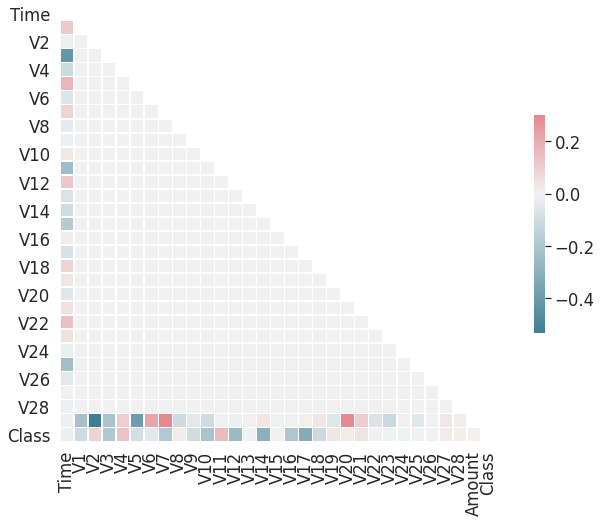

In [8]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Setup matplotlib figure
fig, ax = plt.subplots()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    vmax=.3, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={'shrink': .5}
)

### Response variable distribution

In [9]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [10]:
rsp_classes = ['Genuine', 'Fraud']

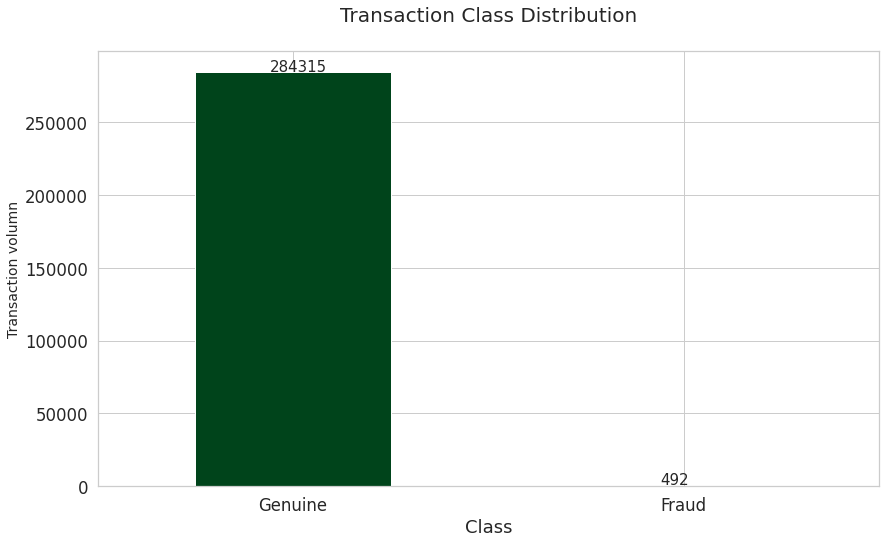

In [11]:
ax = df['Class'].value_counts().plot(kind='bar', rot=0, colormap='Greens_r')
plt.xticks(range(2), rsp_classes)
ax.set_title('Transaction Class Distribution', size=20, pad=30)
ax.set_ylabel('Transaction volumn', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Transaction volumn')

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=15)

Our dataframe is largely imbalanced. *Genuine* transactions exceeds *Fraudulent* transactions

In [12]:
# Transaction types
genuine = df[df.Class == 0]
fraud = df[df.Class == 1]

How different is the "Amount" variable used in different transaction classes?

In [13]:
genuine.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [14]:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

A graphical representation of "Amount" variable

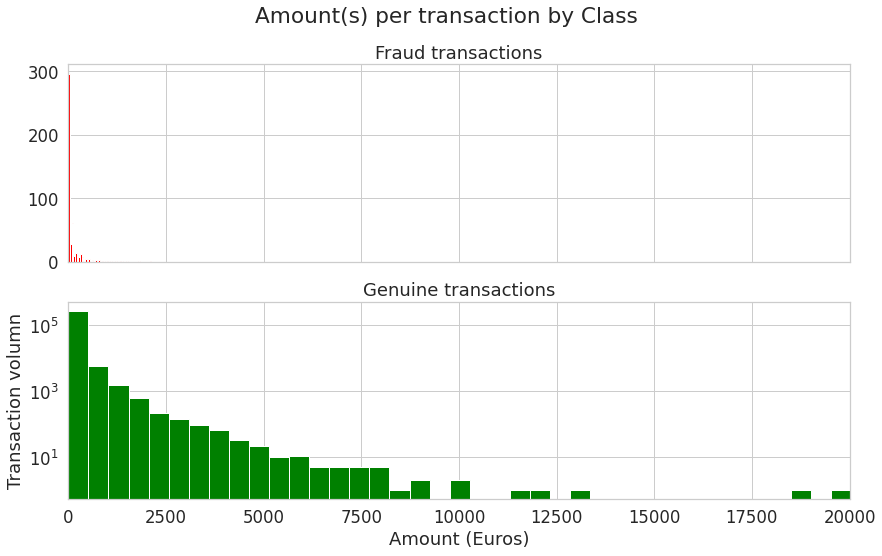

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
fig.suptitle('Amount(s) per transaction by Class')

bins = 50

ax1.hist(fraud.Amount, bins=bins, color='red')
ax1.set_title('Fraud transactions')

ax2.hist(genuine.Amount, bins=bins, color='green')
ax2.set_title('Genuine transactions')

plt.xlabel('Amount (Euros)')
plt.ylabel('Transaction volumn')
plt.xlim(0, 20000)
plt.yscale('log')
plt.show()

Do fraudulent transactions occur more often during certain time?

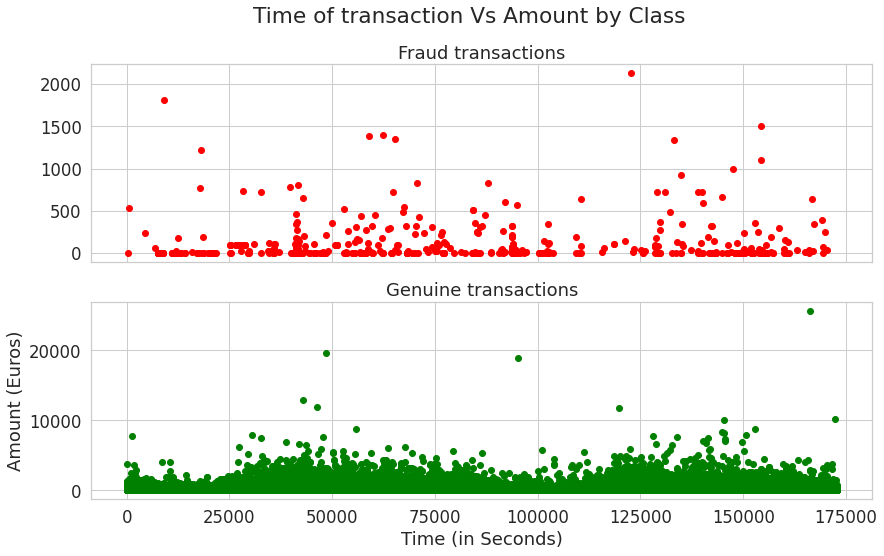

In [16]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
fig.suptitle('Time of transaction Vs Amount by Class')

ax1.scatter(fraud.Time, fraud.Amount, color='red')
ax1.set_title('Fraud transactions')

ax2.scatter(genuine.Time, genuine.Amount, color='green')
ax2.set_title('Genuine transactions')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount (Euros)')
plt.show()

Appears that the "Time" variable of transactions are meaningless

## Data preparation
### Drop variable

In [17]:
# Drop unnecessary variable "Time"
to_drop = ['Time']
data = df.drop(['Time'], axis=1)

### Data scaling
As NNs accept only normalized input vectors, the training data for AE is normalized to fall into the range [0, 1]

In [18]:
from sklearn.preprocessing import StandardScaler

# StandardScaler on the "Amount" variable
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

## What are AutoEncoders?

[Kindly review the README](https://github.com/2series/ex_code/tree/main/card_data/autoencoder)

## Train/Test split
We assume that frauds are *anomalies* in out transactions, *strange, non-standard behaviour*

So, to build an AE that will be able to catch *anomalies* in transactions, we train our model on the *genuine* transactions, only

Reserving the genuine class on the ***Test Set*** will give us a way to evaluate the performance of our AE model

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(
    data, test_size=0.2, random_state=42
)

X_train = X_train[X_train['Class'] == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

In [20]:
X_train.shape

(227451, 29)

## AE architecture

Uses 4 fully-connected feed forward NN layers with 14, 7, 7 and 29 neurons respectively

The first 2 layers are for our Encoder, to produce the code. The last 2 are for the Decoder, to produce the output only using this code

*Additionally, L1 regularization will be used during training*

In [21]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [22]:
input_layer = Input(shape=(input_dim))

encoder = Dense(encoding_dim, 
                activation='tanh', 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), 
                activation='relu')(encoder) 

decoder = Dense(int(encoding_dim / 2), 
                activation='tanh')(encoder)

decoder = Dense(input_dim, 
                activation='relu')(decoder)

ae = Model(inputs=input_layer, outputs=decoder)

We'll train our AE model with Adam optimizer, using MSE as a loss function, for 100 epochs with a batch size of 32 samples

Save the best performing model to a file 

The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands


In [23]:
nb_epoch = 100
batch_size = 32

ae.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model.h5',
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = ae.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
   1/7108 [..............................] - ETA: 0s - loss: 0.7750 - accuracy: 0.0312WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
7108/7108 [==============================] - 10s 1ms/step - loss: 0.8182 - accuracy: 0.5618 - val_loss: 0.7998 - val_accuracy: 0.6209
Epoch 2/100
7108/7108 [==============================] - 11s 2ms/step - loss: 0.7506 - accuracy: 0.6563 - val_loss: 0.7706 - val_accuracy: 0.6856
Epoch 3/100
7108/7108 [==============================] - 10s 1ms/step - loss: 0.7331 - accuracy: 0.6921 - val_loss: 0.7621 - val_accuracy: 0.6902
Epoch 4/100
7108/7108 [==============================] - 10s 1ms/step - loss: 0.7267 - accuracy: 0.6974 - val_loss: 0.7587 - val_accuracy: 0.6984
Epoch 5/100
7108/7108 [=============================

In [24]:
ae = load_model('model.h5')

### Evaluation

### Reconstruction error
We optimize the parameters of our AE model in such way that a special kind of error -> ***reconstruction error*** is minimized

In practice, the traditional squared error is often used

$$\textstyle L(x,x') = ||\, x - x'||^2$$


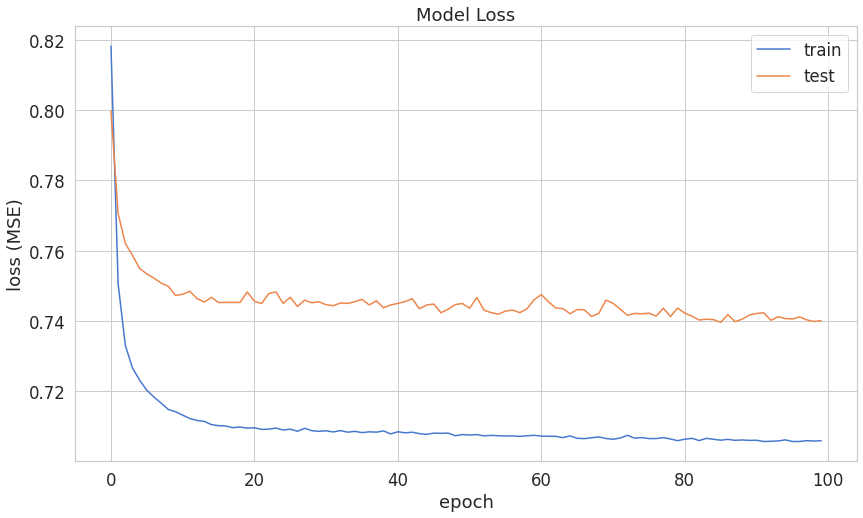

In [25]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

The ***reconstruction error*** on our training and test data seems to converge nicely

>Is it low enough? 

Lets have a closer look at the reconstruction error distribution

In [26]:
preds = ae.predict(X_test)

In [27]:
mse = np.mean(np.power(X_test - preds, 2), axis=1)
error_df = pd.DataFrame({'Class': y_test, 'reconstruction_error': mse})

In [28]:
error_df.describe()

,Class,reconstruction_error
count,56962.000000,56962.000000
mean,0.001720,0.738678
std,0.041443,3.495172
min,0.000000,0.040638
25%,0.000000,0.232560
50%,0.000000,0.383765
75%,0.000000,0.611958
max,1.000000,282.209713


#### Reconstruction error without fraud transactions

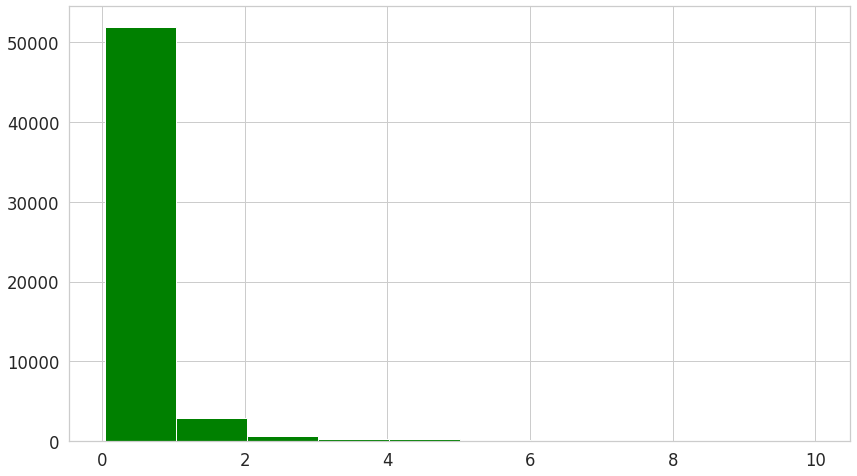

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
genuine_error_df = error_df[(error_df['Class'] == 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(genuine_error_df.reconstruction_error.values, bins=10, color='green')

#### Reconstruction error with fraud transactions

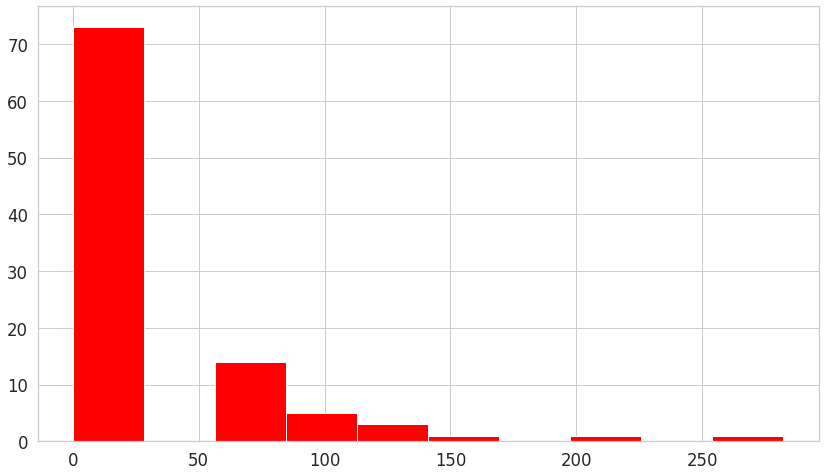

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['Class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10, color='red')

In [31]:
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

Preview confusion matrix

In [32]:
threshold = 2.9

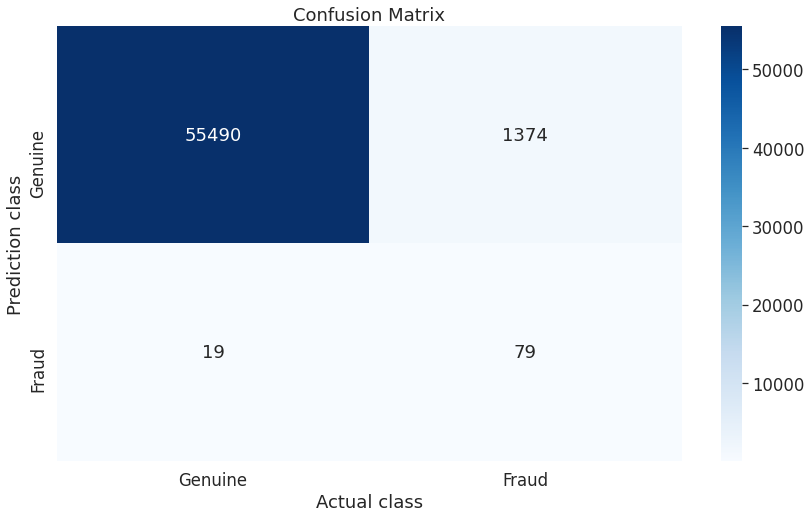

In [33]:
y_pred = [1 if e > threshold else 0 for e in error_df['reconstruction_error'].values]
cm = confusion_matrix(error_df['Class'], y_pred)

plt.figure()
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues', 
    xticklabels=rsp_classes,
    yticklabels=rsp_classes
    )

plt.title('Confusion Matrix')
plt.ylabel('Prediction class')
plt.xlabel('Actual class')
plt.show()

Our AE model seems to catch a lot of the *fraudulent* transactions. Of course, there is a catch (see what I did there?). The number of genuine transactions classified as frauds is really high

>Is this really a problem? It probably is 

We might want to *increase or decrease* the value of our threshold, depending on the problem

We'll leave that up to you

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit special

>We have a very imbalanced dataset

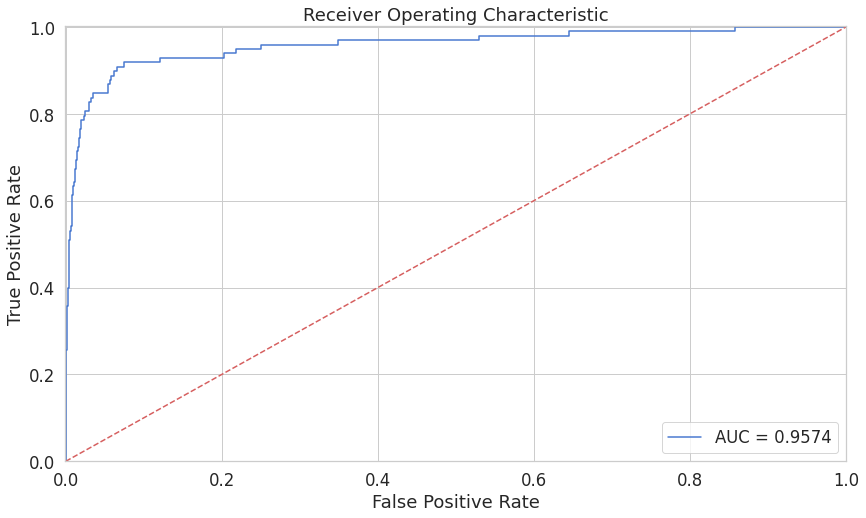

In [34]:
fpr, tpr, thresholds = roc_curve(error_df['Class'], error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001,1])
plt.ylim([0,1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The ROC curve plots the TPR Vs the FPR, over different threshold values 

Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind the nature of our dataset 

ROC doesn't look very useful for us. Onward...

### Precision vs Recall

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png" />

Precision

$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$$

Recall

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$

Lets take an example from Information Retrieval in order to better understand what Precision and Recall are 

>Precision measures the relevancy of obtained results 

>Recall, on the other hand, measures how many relevant results are returned 

***Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1***

Lets return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy 

When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant

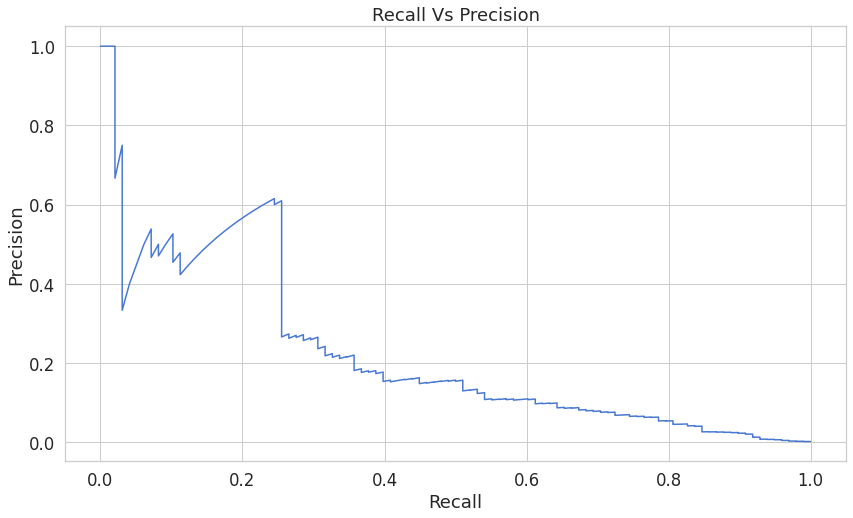

In [35]:
precision, recall, th = precision_recall_curve(error_df['Class'], error_df['reconstruction_error'])
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall Vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high Recall and high Precision, where high Precision relates to a low False Positive Rate, and high recall relates to a low False Negative Rate 

High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall)

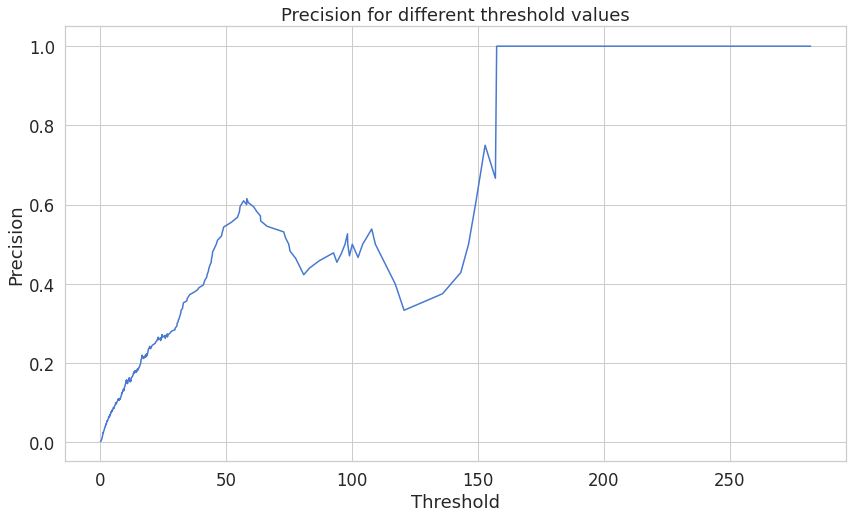

In [36]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

We can see that as the ***reconstruction error*** increases our Precision rises as well. Lets have a look at the Recall

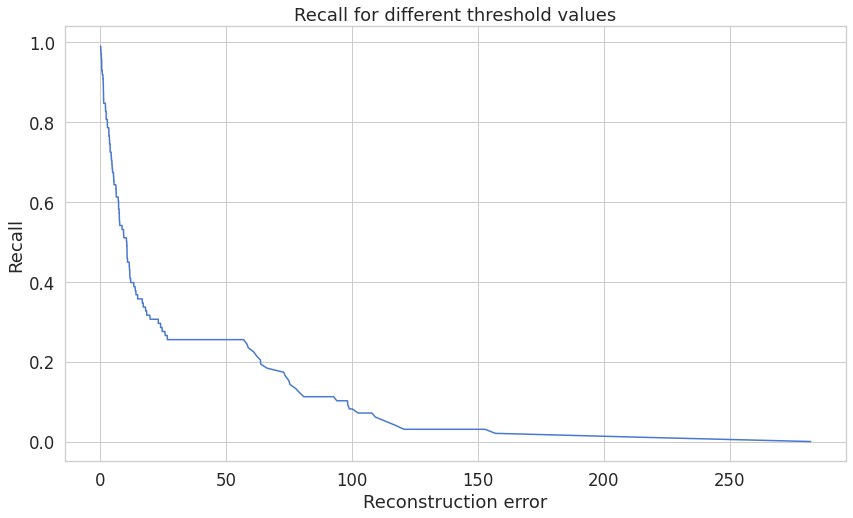

In [37]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the ***reconstruction error*** increases the Recall decreases

## Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a New/Unseen transaction(s) are Genuine OR Fraudulent, we'll compute the reconstruction error from the transaction data itself (test sample)

If the error is larger than a predefined threshold, we'll mark it as a fraud *(since our model should have a low error on genuine transactions)*

We'll see how well we're dividing the 2 types of transactions

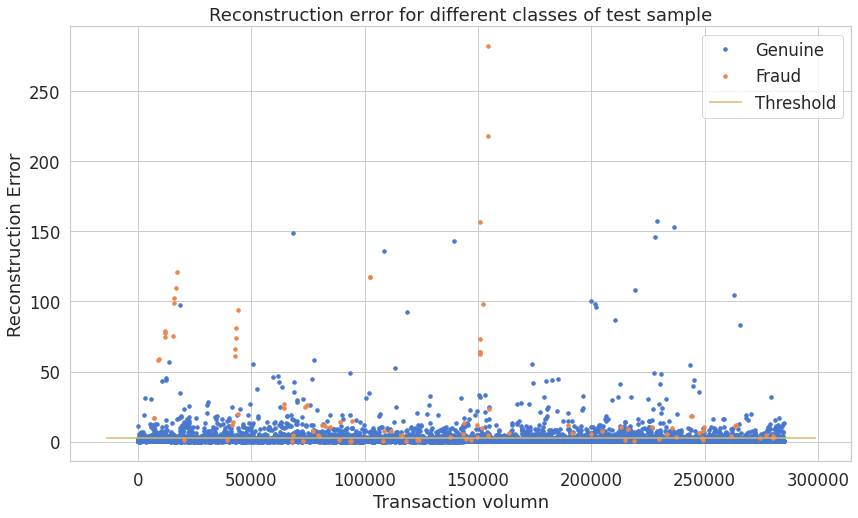

In [38]:
groups = error_df.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(
        group.index, 
        group.reconstruction_error, 
        marker='o',
        ms=3.5, 
        linestyle='',
        label= 'Genuine' if name == 0 else 'Fraud'
    )

ax.hlines(
    threshold, 
    ax.get_xlim()[0], 
    ax.get_xlim()[1], 
    colors='y', 
    zorder=100, 
    label='Threshold'
)

ax.legend()
plt.title('Reconstruction error for different classes of test sample')
plt.ylabel('Reconstruction Error')
plt.xlabel('Transaction volumn')
plt.show()

## Conclusion

We've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples, *Genuine transactions*, to a model and it learned (somewhat) how to discriminate whether or not New transactions/examples belong to that same class

>That's cool? 

Our dataset was kind of magical, though. We *really* do not know what the original variables look like

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one

>*Can you apply a similar model to a different problem?*